### MACHINE LEARNING

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge


In [2]:
df = pd.read_csv("mxmh survey results2.csv")

df = df[  ['Anxiety', 'Age', 'Hours per day', 'BPM']  ]

df.describe()

,Anxiety,Age,Hours per day,BPM
count,624.000000,624.000000,624.000000,624.000000
mean,5.866186,24.753205,3.713462,123.214744
std,2.767640,11.709293,3.092419,32.899605
min,0.000000,10.000000,0.000000,4.000000
25%,4.000000,18.000000,2.000000,100.000000
50%,6.000000,21.000000,3.000000,120.000000
75%,8.000000,27.000000,5.000000,144.000000
max,10.000000,89.000000,24.000000,220.000000


In [3]:
# Define
target = "Anxiety"
features = ["Age", "Hours per day", "BPM"]

data = df[features + [target]].copy()

for col in features + [target]:
    data[col] = pd.to_numeric(data[col], errors="coerce")

data = data.dropna(subset=[target])


In [4]:
target = "Anxiety"
features = ["Age", "Hours per day", "BPM"]

# X（features）：Age, Hours per day, BPM
# Y（target）：Anxiety

In [5]:
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42 )

X_train.shape, X_test.shape


((436, 3), (188, 3))

### Linear Regression

In [6]:
# Liner Regression
from sklearn.linear_model import LinearRegression

pipe_lr = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", LinearRegression())])

pipe_lr.fit(X_train, y_train)


# Validation

y_pred = pipe_lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Linear Regression (Test Set)")
print(f"MAE:  {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R^2:  {r2:.3f}")



Linear Regression (Test Set)
MAE:  2.453
RMSE: 2.928
R^2:  0.005


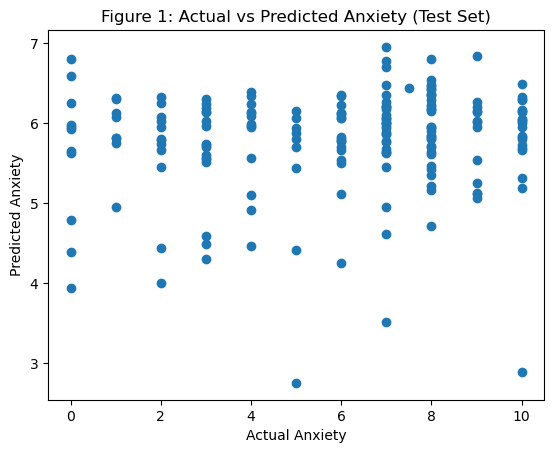

In [7]:
# Draw a Picture

def plot_actual_vs_predicted(num=1):
    """
    Scatter plot of actual vs predicted anxiety (Linear Regression)
    """

    plt.figure()
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Anxiety")
    plt.ylabel("Predicted Anxiety")
    plt.title(f"Figure {num}: Actual vs Predicted Anxiety (Test Set)")
    plt.show()
plot_actual_vs_predicted()

In [8]:
# From this result, we can tell the reliability of the predicted data compared with the actual data. 
# MAE is 2.453, which means the predicted data is 2.453/10 far from the actual result. This number is not high, but not small enough to be 100% trusted.
# The result of R^2 means that age, hours of music listening per day, and BPM alone explain little variance in anxiety level.
# Anxiety is a really complex mental status that hundreds of factors could influence so it's not surprising to see this result. 
# But to see whether there are better results, I will try another regression model.

### Ridge Regression

In [9]:
# Ridge Regression Pipeline

pipe_ridge = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("model", Ridge(alpha=1.0))])

# Fit model
pipe_ridge.fit(X_train, y_train)

# Predict on test set
y_pred_r = pipe_ridge.predict(X_test)

# Evaluation metrics (old sklearn compatible)
mae_r = mean_absolute_error(y_test, y_pred_r)
mse_r = mean_squared_error(y_test, y_pred_r)
rmse_r = np.sqrt(mse_r)
r2_r = r2_score(y_test, y_pred_r)

print("Ridge Regression (Test Set)")
print(f"MAE:  {mae_r:.3f}")
print(f"RMSE: {rmse_r:.3f}")
print(f"R^2:  {r2_r:.3f}")



Ridge Regression (Test Set)
MAE:  2.453
RMSE: 2.928
R^2:  0.005


In [10]:
# 5-fold cross-validation for Ridge Regression
cv_r2 = cross_val_score(pipe_ridge, X, y, cv=5, scoring="r2")

print("5-fold CV R^2 scores:", np.round(cv_r2, 4))
print(f"Mean R^2: {cv_r2.mean():.4f}")
print(f"Std  R^2: {cv_r2.std():.4f}")


5-fold CV R^2 scores: [-0.0804  0.0162  0.0604  0.0562  0.0313]
Mean R^2: 0.0167
Std  R^2: 0.0512


In [11]:
# To see the importance of each feature (Ridge Regression)

coef = pipe_ridge.named_steps["model"].coef_

coef_df = pd.DataFrame({ "feature": features, "coefficient": coef}).sort_values("coefficient", ascending=False)

coef_df


,feature,coefficient
2,BPM,0.289826
1,Hours per day,0.149031
0,Age,-0.445992


In [12]:
# Regularization does not significantly improve predictive performance compared to standard linear regression.
# In 5-fold cross-validation, the dataset is split into five parts. The model is trained on four parts and tested on the remaining one, and this process is repeated five times.
# The cross-validation results show that the model performs poorly across different data splits. R2 is very low...
# This means that age, hours of music listening per day, and BPM do not provide enough information to reliably predict anxiety levels.

### The results above suggest that anxiety is influenced by many complex factors, and these basic numerical variables alone are not sufficient for accurate prediction. 
### Therefore, it is reasonable that the model does not show strong predictive performance.

In [13]:
results_df = pd.DataFrame({ "Model": ["Linear Regression", "Ridge Regression"],  "MAE": [mae, mae_r],  "RMSE": [rmse, rmse_r], "R^2": [r2, r2_r]})

results_df




,Model,MAE,RMSE,R^2
0,Linear Regression,2.452582,2.927868,0.004944
1,Ridge Regression,2.452610,2.927734,0.005036


In [14]:
results_df_fmt = results_df.copy()

for col in ["MAE", "RMSE", "R^2"]:
    results_df_fmt[col] = results_df_fmt[col].apply(lambda x: f"{x:.3g}")


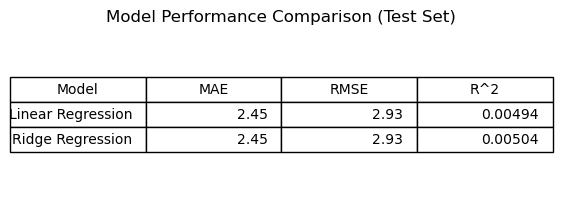

In [15]:
# Figure
import pandas as pd
import matplotlib.pyplot as plt

results_df = pd.DataFrame({ "Model": ["Linear Regression", "Ridge Regression"], "MAE": [mae, mae_r], "RMSE": [rmse, rmse_r], "R^2": [r2, r2_r]})

def plot_machine():
    results_df_fmt = results_df.copy()

    for col in ["MAE", "RMSE", "R^2"]:
        results_df_fmt[col] = results_df_fmt[col].apply(lambda x: f"{x:.3g}")

    fig, ax = plt.subplots(figsize=(7, 2.2))
    ax.axis("off")

    table = ax.table(cellText=results_df_fmt.values, colLabels=results_df_fmt.columns, loc="center")

    table.scale(1, 1.5)
    table.auto_set_font_size(False)
    table.set_fontsize(10)

    ax.set_title("Model Performance Comparison (Test Set)")
    plt.show()

plot_machine()


In [16]:
print("pipe_lr exists:", "pipe_lr" in globals())
print("pipe_ridge exists:", "pipe_ridge" in globals())
print("X_test exists:", "X_test" in globals())


pipe_lr exists: True
pipe_ridge exists: True
X_test exists: True


## However, there seem to be some problems with the data and the regression method I've used. Anxiety rate is a bounded ordinal data that cannot be analysed with linear regression, which leads to non-ideal results. Thus, after researching online, I will try to use ordinal logistic regression to continue further analysis.

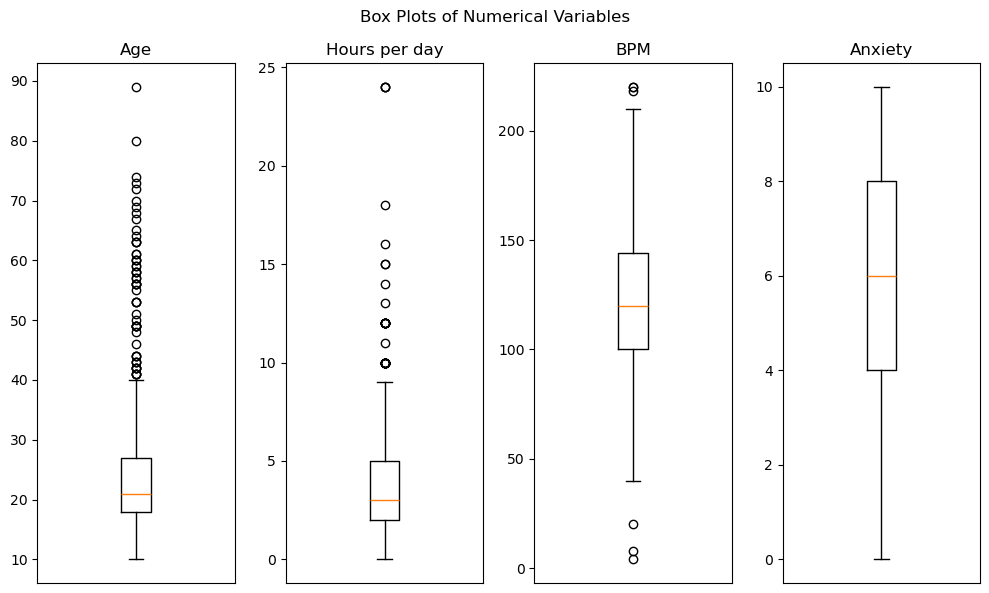

In [17]:
cols = ["Age", "Hours per day", "BPM", "Anxiety"]
box_data = df[cols].apply(pd.to_numeric, errors="coerce")

plt.figure(figsize=(10, 6))

for i, col in enumerate(cols, 1):
    plt.subplot(1, 4, i)
    plt.boxplot(box_data[col].dropna())
    plt.title(col)
    plt.xticks([])

plt.suptitle("Box Plots of Numerical Variables")
plt.tight_layout()
plt.show()


C:\Users\dell\AppData\Local\Temp\ipykernel_3432\876071638.py:20: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_values, labels=[f"{g}-{g+9}" for g in groups])


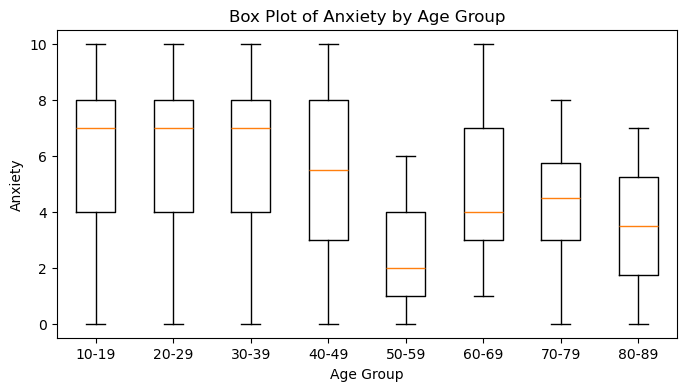

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Select needed columns
data_box = df[["Age", "Anxiety"]].apply(pd.to_numeric, errors="coerce")
data_box = data_box.dropna()

# Create age groups (10-year bins)
data_box["Age_group"] = (data_box["Age"] // 10 * 10).astype(int)

# Prepare data for boxplot
groups = sorted(data_box["Age_group"].unique())
box_values = [
    data_box.loc[data_box["Age_group"] == g, "Anxiety"]
    for g in groups
]

# Plot
plt.figure(figsize=(8, 4))
plt.boxplot(box_values, labels=[f"{g}-{g+9}" for g in groups])

plt.xlabel("Age Group")
plt.ylabel("Anxiety")
plt.title("Box Plot of Anxiety by Age Group")
plt.show()


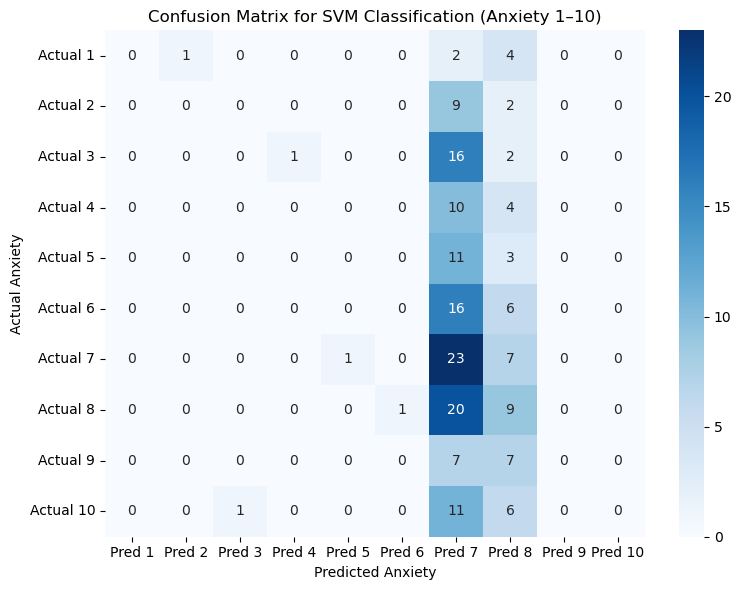

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

# ---- Data preparation ----
cols = ["Age", "BPM", "Hours per day", "Anxiety"]
data = df[cols].copy()

for c in cols:
    data[c] = pd.to_numeric(data[c], errors="coerce")

data = data.dropna(subset=["Anxiety"])

X = data[["Age", "BPM", "Hours per day"]]
y = data["Anxiety"].astype(int)   # discrete classes 1–10

# ---- Train / Test split ----
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# ---- SVM classification pipeline ----
pipe_svc = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="rbf"))
])

pipe_svc.fit(X_train, y_train)

# ---- Prediction ----
y_pred = pipe_svc.predict(X_test)

# ---- Confusion matrix (classes 1–10) ----
labels = list(range(1, 11))
cm = confusion_matrix(y_test, y_pred, labels=labels)

cm_df = pd.DataFrame(
    cm,
    index=[f"Actual {i}" for i in labels],
    columns=[f"Pred {i}" for i in labels]
)

cm_df
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df,
    cmap="Blues",
    annot=True,
    fmt="d",
    cbar=True
)

plt.xlabel("Predicted Anxiety")
plt.ylabel("Actual Anxiety")
plt.title("Confusion Matrix for SVM Classification (Anxiety 1–10)")
plt.tight_layout()
plt.show()

In [20]:
# The result is not ideal, so I want to check if there are unexpected outliers that contaminated data. 

C:\Users\dell\AppData\Local\Temp\ipykernel_3432\1541306396.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(box_data, labels=valid_labels)


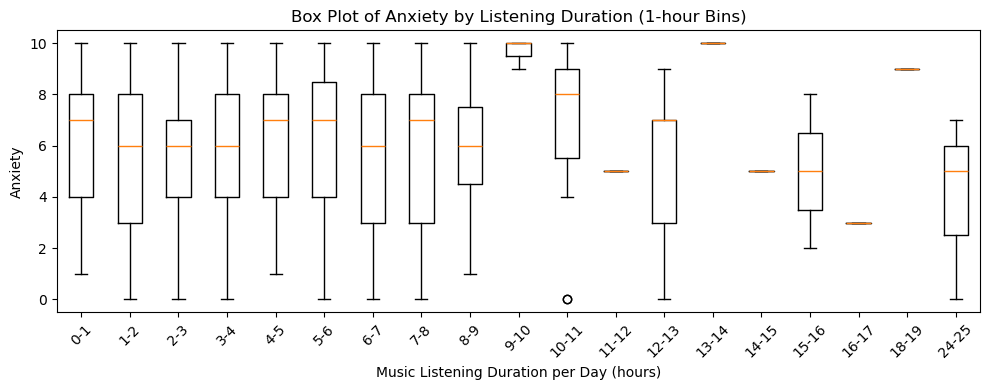

In [27]:
data = df[["Hours per day", "Anxiety"]].copy()

data["Hours per day"] = pd.to_numeric(data["Hours per day"], errors="coerce")
data["Anxiety"] = pd.to_numeric(data["Anxiety"], errors="coerce")

data = data.dropna()

max_hour = int(data["Hours per day"].max()) + 1
bins = list(range(0, max_hour + 1))
labels = [f"{i}-{i+1}" for i in range(len(bins) - 1)]

data["Duration_group"] = pd.cut( data["Hours per day"], bins=bins, labels=labels, include_lowest=True, right=False)

box_data = [data.loc[data["Duration_group"] == g, "Anxiety"]
    for g in labels
    if not data.loc[data["Duration_group"] == g, "Anxiety"].empty ]

valid_labels = [g for g in labels
    if not data.loc[data["Duration_group"] == g, "Anxiety"].empty]

plt.figure(figsize=(10, 4))
plt.boxplot(box_data, labels=valid_labels)

plt.xlabel("Music Listening Duration per Day (hours)")
plt.ylabel("Anxiety")
plt.title("Box Plot of Anxiety by Listening Duration (1-hour Bins)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [22]:
# The data (duration more than 9 hours) may not be the concern of this study. We will only be focusing on duration 0-9.

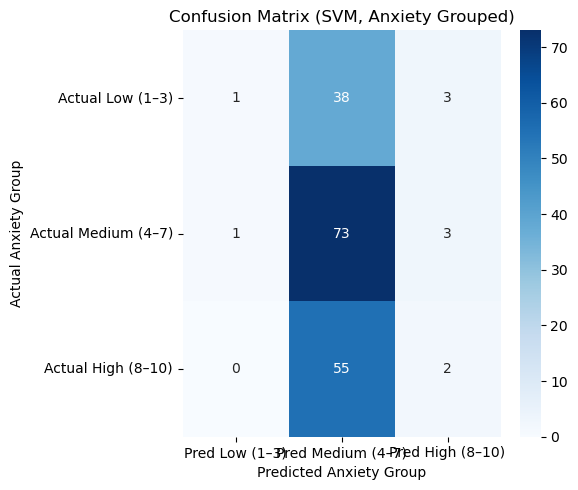

In [33]:

from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

def plot_svm():
    
    cols = ["Age", "BPM", "Hours per day", "Anxiety"]
    data = df[cols].copy()
    
    for c in cols:
        data[c] = pd.to_numeric(data[c], errors="coerce")
    
    data = data.dropna(subset=["Anxiety"])
    
    data = data[data["Hours per day"] <= 9]
    
    def anxiety_group(x):
        if x <= 3:
            return "Low (1–3)"
        elif x <= 7:
            return "Medium (4–7)"
        else:
            return "High (8–10)"
    
    data["Anxiety_group"] = data["Anxiety"].apply(anxiety_group)
    
    X = data[["Age", "BPM", "Hours per day"]]
    y = data["Anxiety_group"]
    
    X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.30, random_state=42,  stratify=y)
    
    pipe_svc = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()), ("svc", SVC(kernel="rbf"))])
    
    pipe_svc.fit(X_train, y_train)
    
    
    y_pred = pipe_svc.predict(X_test)
    
    labels = ["Low (1–3)", "Medium (4–7)", "High (8–10)"]
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    cm_df = pd.DataFrame( cm, index=[f"Actual {l}" for l in labels], columns=[f"Pred {l}" for l in labels])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_df,cmap="Blues", annot=True, fmt="d", cbar=True)
    
    plt.xlabel("Predicted Anxiety Group")
    plt.ylabel("Actual Anxiety Group")
    plt.title("Confusion Matrix (SVM, Anxiety Grouped)")
    plt.tight_layout()
    plt.show()

plot_svm()


In [ ]:
# According to the figure, we can tell that the model shows relatively high performance on the data with an anxiety rate under 7, which means medium-low anxiety groups.

In [43]:
from sklearn.model_selection import StratifiedKFold

def validation2():
    cols = ["Age", "BPM", "Hours per day", "Anxiety"]
    data = df[cols].copy()

    for c in cols:
        data[c] = pd.to_numeric(data[c], errors="coerce")

    data = data.dropna(subset=["Anxiety"])
    data = data[data["Hours per day"] <= 9]

    def anxiety_group(x):
        if x <= 3:
            return "Low (1–3)"
        elif x <= 7:
            return "Medium (4–7)"
        else:
            return "High (8–10)"

    data["Anxiety_group"] = data["Anxiety"].apply(anxiety_group)

    X = data[["Age", "BPM", "Hours per day"]]
    y = data["Anxiety_group"]

    X_train, _, y_train, _ = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y )

    svm_model = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf"))])

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(svm_model, X_train, y_train, cv=cv, scoring="accuracy" )

    results_df = pd.DataFrame({
        "Fold": [f"Fold {i+1}" for i in range(5)] + ["Mean", "Std"],
        "Accuracy": list(cv_scores) + [cv_scores.mean(), cv_scores.std()] })

    results_df["Accuracy"] = results_df["Accuracy"].apply(lambda x: f"{x:.3g}")
    return results_df

svm_results = validation2()
svm_results


,Fold,Accuracy
0,Fold 1,0.426
1,Fold 2,0.415
2,Fold 3,0.415
3,Fold 4,0.441
4,Fold 5,0.473
5,Mean,0.434
6,Std,0.0218


In [ ]:
# The SVM model achieved a mean classification accuracy of 0.434, with fold accuracies ranging from 0.415 to 0.473
# The relatively small standard deviation (0.022) indicates that the model performance is stable across different folds.
# However, the overall accuracy is modest, suggesting that age, music BPM, and listening duration alone provide limited information for predicting anxiety levels.
# This result is reasonable, as anxiety is influenced by many psychological and complex factors that are not captured by these basic numerical variables and not included in this study.
